# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review



In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\LiGht\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 60000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (60000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(54458, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

90.76333333333334

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(54456, 10)


1    45572
0     8884
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.
THIS BREAD MIX IS THE CLOSEST THING TO REGULAR BREAD I HAVE FOUND. EASY TO MAKE IN MY BREAD MACHINE.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.
THIS BREAD MIX IS THE CLOSEST THING TO REGULAR BREAD I HAVE FOUND. EASY TO MAKE IN MY BREAD MACHINE.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he has not had a UTI for a year.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My husband is a paraplegic and was having UTIs constantly Since he started drinking a cup of this tea every morning he has not had a UTI for a year 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 54456/54456 [00:29<00:00, 1825.67it/s]


In [23]:
preprocessed_reviews[1500]

'husband paraplegic utis constantly since started drinking cup tea every morning not uti year'

# [5] Assignment 3: KNN

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentationv
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn import datasets, neighbors
final['CleanedText']=preprocessed_reviews
print(final.shape)
final.head(3)

In [28]:
labels=final['Score'].values

X = final['CleanedText'].values
Y = labels[0:60000]

In [29]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)



(24444,) (24444,)
(12041,) (12041,)
(17971,) (17971,)
After vectorizations
(24444, 29569) (24444,)
(12041, 29569) (12041,)
(17971, 29569) (17971,)


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_train_bow, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv_bow)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(X_train_bow,y_train)
pred = knn.predict(X_test_bow)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 58%

CV accuracy for k = 3 is 81%

CV accuracy for k = 5 is 83%

CV accuracy for k = 7 is 83%

CV accuracy for k = 9 is 84%

CV accuracy for k = 11 is 84%

CV accuracy for k = 13 is 84%

CV accuracy for k = 15 is 84%

CV accuracy for k = 17 is 84%

CV accuracy for k = 19 is 84%

CV accuracy for k = 21 is 84%

CV accuracy for k = 23 is 84%

CV accuracy for k = 25 is 84%

CV accuracy for k = 27 is 84%

CV accuracy for k = 29 is 84%

****Test accuracy for k = 1 is 58%


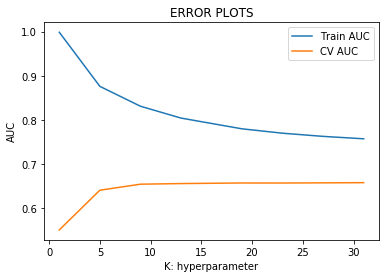

In [34]:

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [32]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 10

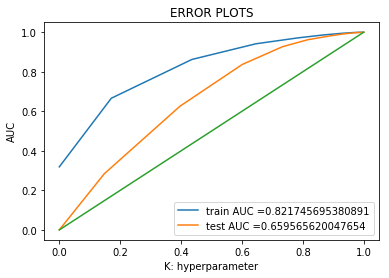

Train confusion matrix
[[  868  3141]
 [  585 19850]]
Test confusion matrix
[[  548  2448]
 [  563 14412]]


In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='-')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

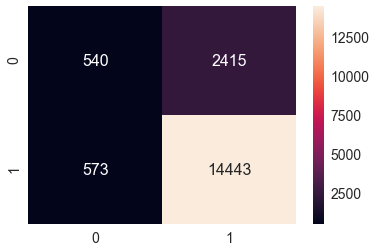

In [110]:
df_cm = pd.DataFrame(confusion_matrix(y_test,neigh.predict(X_test_bow)), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g') 

# [5.1.2] Applying KNN brute force on TFIDF, SET 2

In [36]:
labels=final['Score'].values

# Picking the top 3000 points as TSNE
X = final['CleanedText'].values
Y = labels[0:60000]

In [37]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


(24444,) (24444,)
(12041,) (12041,)
(17971,) (17971,)
After vectorizations
(24444, 14754) (24444,)
(12041, 14754) (12041,)
(17971, 14754) (17971,)


In [38]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_train_tfidf, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv_tfidf)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(X_train_tfidf,y_train)
pred = knn.predict(X_test_tfidf)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 18%

CV accuracy for k = 3 is 83%

CV accuracy for k = 5 is 83%

CV accuracy for k = 7 is 83%

CV accuracy for k = 9 is 83%

CV accuracy for k = 11 is 83%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%

****Test accuracy for k = 1 is 19%


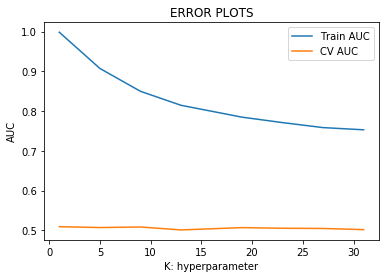

In [39]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [40]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 15

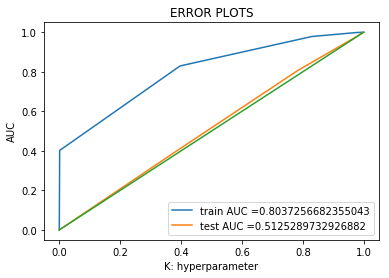

Train confusion matrix
[[    1  3961]
 [    0 20482]]
Test confusion matrix
[[    0  2982]
 [    0 14989]]


In [41]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='-')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_tfidf)))

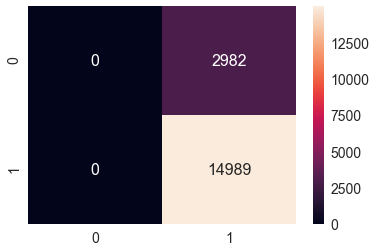

In [43]:
df_cm = pd.DataFrame(confusion_matrix(y_test,neigh.predict(X_test_tfidf)), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [47]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [48]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [49]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9561
sample words  ['first', 'let', 'note', 'several', 'different', 'manufacturers', 'liter', 'bottles', 'coconut', 'water', 'tried', 'variety', 'zico', 'vita', 'coco', 'brand', 'comparable', 'price', 'quality', 'delicious', 'though', 'half', 'people', 'office', 'shared', 'opinion', 'young', 'may', 'something', 'specific', 'taste', 'fan', 'refreshing', 'served', 'cold', 'claim', 'naturally', 'contain', 'compounds', 'found', 'sports', 'drinks', 'supposed', 'speed', 'hydration', 'take', 'grain', 'salt', 'well', 'anything']


In [50]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 24444/24444 [00:56<00:00, 430.67it/s]


(24444, 50)
[ 0.43247522 -0.09394554 -0.19135843 -0.74917369 -0.36010228 -0.37993512
 -0.11479583 -0.00552479  0.15304545  0.38136596 -0.12467197 -0.78544323
 -0.39858801 -0.42963016 -0.60988475 -0.26259435 -0.24564034 -0.81710561
 -0.11829477  0.14529685  0.14790863  0.95357371  0.26514174  0.41468022
 -0.36077042 -0.22574085 -0.37042868  0.33099637  0.04287867 -0.29721444
  0.5377062   0.28280644  1.00767319  0.50423193  0.42491817 -0.11281207
 -0.0967483  -0.1502156  -0.45323619 -0.08725805  0.0343452  -0.10334446
  0.00608941 -0.10058606  0.07585213 -0.26854021  0.43184693 -0.2108729
 -0.12442533 -0.16032227]


In [51]:
#converting cv data to text
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [52]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 12041/12041 [00:24<00:00, 497.31it/s]


(12041, 50)
[ 0.06234255 -0.17772036  0.07662861 -0.42065322 -0.19563079  0.3207355
 -0.57047563  0.01140595  0.3574201  -0.07588322 -0.14814894 -0.78905655
  0.0478141  -0.13970997 -0.35900688 -0.6290634  -0.23078332 -0.95376563
 -0.38496259 -0.16423069  0.25718834  1.15024551 -0.29732683 -0.31237672
 -0.13630309  0.36956019 -0.51339056 -0.37531172 -0.24112315  0.10523113
  0.70023167 -0.57266284  0.92342672 -0.33728549  0.28483959 -0.4207257
 -0.36562669  0.03359561 -0.17986683 -0.2253657  -0.73294323  0.15339554
 -0.61199305 -0.021836   -0.6272587  -0.21703494  0.61154329  0.78865053
 -0.4716727  -0.34400492]


In [53]:
#Converting Test data text
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [54]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 17971/17971 [00:35<00:00, 505.11it/s]


(17971, 50)
[ 0.3858735  -0.39026004  0.02754255 -0.76507849 -0.23153357 -0.14986747
 -0.356403   -0.11380601  0.03771016  0.2283213  -0.04541662 -0.03322412
 -0.35482734 -0.31712703 -0.2690745  -0.14594315 -0.40676355 -0.78665534
 -0.50866796  0.24880895 -0.05003993  0.52475111 -0.04610269 -0.14979051
 -0.05597861  0.07557114 -0.45998481 -0.18232281  0.1788239  -0.09267201
  0.40464319 -0.15794525  0.71578449  0.03544322  0.17878268 -0.13241757
  0.0201125   0.2089669  -0.18075605 -0.22829545 -0.18260258 -0.13401261
 -0.28969943  0.34808375 -0.51818857 -0.06300057  0.25273743 -0.00209067
 -0.07497776 -0.04777605]


In [55]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(sent_vectors_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(sent_vectors_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(sent_vectors_train,y_train)
pred = knn.predict(sent_vectors_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 81%

CV accuracy for k = 3 is 84%

CV accuracy for k = 5 is 85%

CV accuracy for k = 7 is 85%

CV accuracy for k = 9 is 86%

CV accuracy for k = 11 is 86%

CV accuracy for k = 13 is 86%

CV accuracy for k = 15 is 86%

CV accuracy for k = 17 is 86%

CV accuracy for k = 19 is 86%

CV accuracy for k = 21 is 86%

CV accuracy for k = 23 is 86%

CV accuracy for k = 25 is 86%

CV accuracy for k = 27 is 86%

CV accuracy for k = 29 is 86%

****Test accuracy for k = 1 is 81%


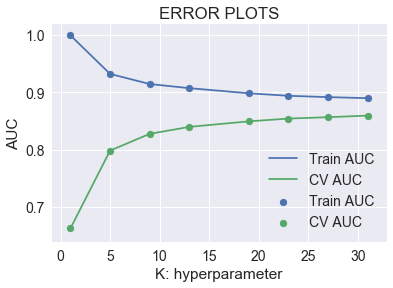

In [56]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

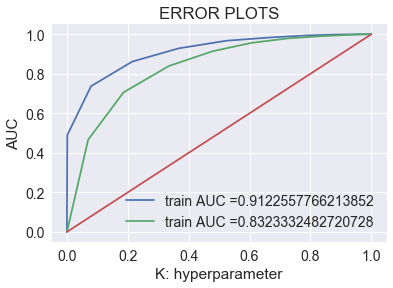

Train confusion matrix
[[ 1884  2078]
 [  669 19813]]
Test confusion matrix
[[ 1175  1807]
 [  654 14335]]


In [57]:
neigh = KNeighborsClassifier(n_neighbors=10,algorithm='brute')
neigh.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

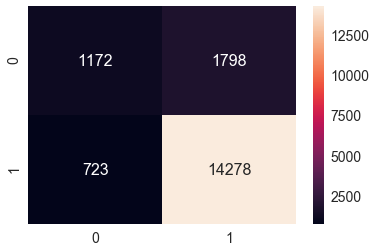

In [62]:
df_cm = pd.DataFrame(confusion_matrix(y_test,neigh.predict(sent_vectors_test)), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [58]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(24444,) (24444,)
(12041,) (12041,)
(17971,) (17971,)


In [59]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [60]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 24444/24444 [11:48<00:00, 34.50it/s]


In [61]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_cv_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 12041/12041 [02:34<00:00, 77.95it/s]


In [63]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [64]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17971/17971 [04:50<00:00, 61.80it/s]


In [65]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(tfidf_train_sent_vectors, y_train)
    
    pred = knn.predict(tfidf_cv_sent_vectors)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(tfidf_train_sent_vectors,y_train)
pred = knn.predict(tfidf_test_sent_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 72%

CV accuracy for k = 3 is 78%

CV accuracy for k = 5 is 81%

CV accuracy for k = 7 is 82%

CV accuracy for k = 9 is 83%

CV accuracy for k = 11 is 83%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%

****Test accuracy for k = 1 is 72%


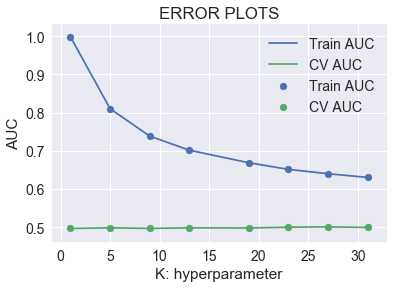

In [66]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(tfidf_train_sent_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_train_sent_vectors)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_cv_sent_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

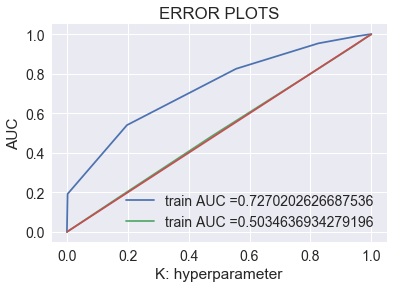

Train confusion matrix
[[  173  3827]
 [  185 20259]]
Test confusion matrix
[[   42  2875]
 [  214 14840]]


In [67]:
neigh = KNeighborsClassifier(n_neighbors=10,algorithm='brute')
neigh.fit(tfidf_train_sent_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_train_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_test_sent_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='-')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(tfidf_train_sent_vectors)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(tfidf_test_sent_vectors)))

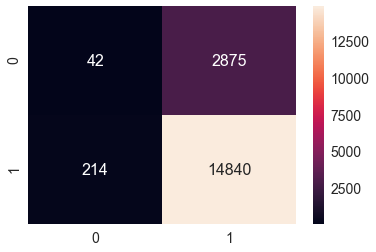

In [68]:
df_cm = pd.DataFrame(confusion_matrix(y_test,neigh.predict(tfidf_test_sent_vectors)), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [69]:
# Please write all the code with proper documentation
labels=final['Score'].values

# Picking the top 3000 points as TSNE
X = final['CleanedText'].values
Y = labels[0:60000]

In [70]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10, max_features=500)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

(24444,) (24444,)
(12041,) (12041,)
(17971,) (17971,)
After vectorizations
(24444, 500) (24444,)
(12041, 500) (12041,)
(17971, 500) (17971,)


In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_train_bow, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv_bow)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(X_train_bow,y_train)
pred = knn.predict(X_test_bow)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 75%

CV accuracy for k = 3 is 80%

CV accuracy for k = 5 is 81%

CV accuracy for k = 7 is 82%

CV accuracy for k = 9 is 83%

CV accuracy for k = 11 is 83%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%

****Test accuracy for k = 1 is 75%


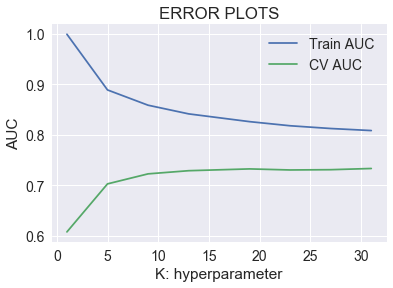

In [72]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [73]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 10

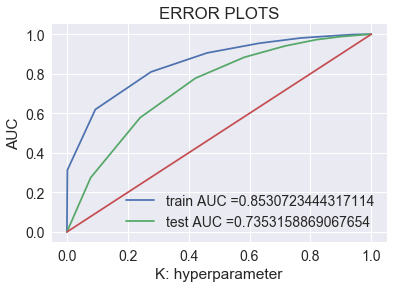

Train confusion matrix
[[ 1431  2452]
 [  936 19625]]
Test confusion matrix
[[  840  2131]
 [  886 14114]]


In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='-')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

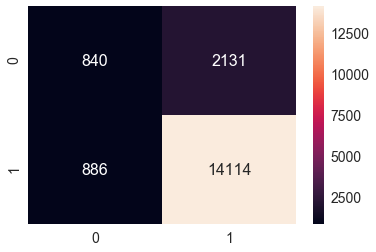

In [75]:
df_cm = pd.DataFrame(confusion_matrix(y_test,neigh.predict(X_test_bow)), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g') 

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [76]:
# Please write all the code with proper documentation
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


After vectorizations
(24444, 14690) (24444,)
(12041, 14690) (12041,)
(17971, 14690) (17971,)


In [77]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_train_tfidf, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv_tfidf)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(X_train_tfidf,y_train)
pred = knn.predict(X_test_tfidf)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 83%

CV accuracy for k = 3 is 83%

CV accuracy for k = 5 is 83%

CV accuracy for k = 7 is 83%

CV accuracy for k = 9 is 83%

CV accuracy for k = 11 is 83%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%

****Test accuracy for k = 1 is 83%


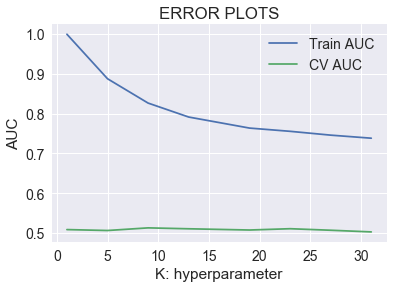

In [78]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [81]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 15

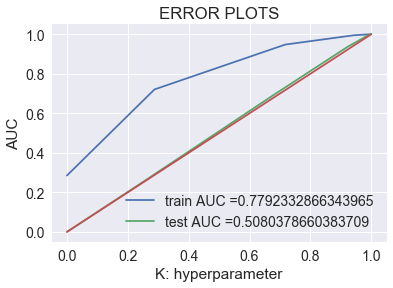

Train confusion matrix
[[    0  3883]
 [    0 20561]]
Test confusion matrix
[[    0  2971]
 [    0 15000]]


In [82]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
neigh.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='-')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_tfidf)))

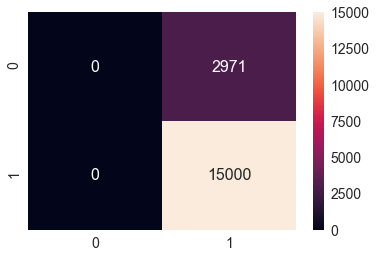

In [83]:
df_cm = pd.DataFrame(confusion_matrix(y_test,neigh.predict(X_test_tfidf)), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [84]:
# Please write all the code with proper documentation
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(sent_vectors_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(sent_vectors_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(sent_vectors_train,y_train)
pred = knn.predict(sent_vectors_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 72%

CV accuracy for k = 3 is 78%

CV accuracy for k = 5 is 80%

CV accuracy for k = 7 is 81%

CV accuracy for k = 9 is 82%

CV accuracy for k = 11 is 82%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%

****Test accuracy for k = 1 is 73%


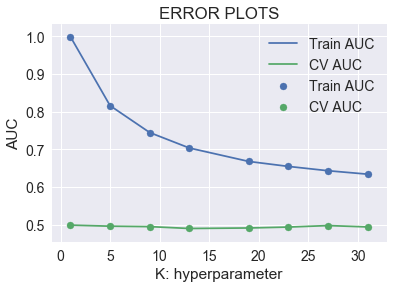

In [89]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

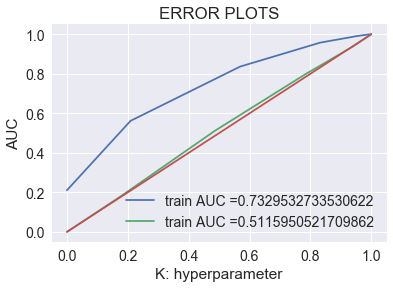

Train confusion matrix
[[  171  3712]
 [  172 20389]]
Test confusion matrix
[[   38  2933]
 [  201 14799]]


In [90]:
neigh = KNeighborsClassifier(n_neighbors=10,algorithm='kd_tree')
neigh.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))

plt.plot([0, 1], [0, 1], linestyle='-')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

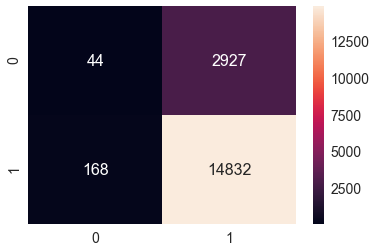

In [91]:
df_cm = pd.DataFrame(confusion_matrix(y_test,neigh.predict(tfidf_test_sent_vectors)), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [92]:
# Please write all the code with proper documentation
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(tfidf_train_sent_vectors, y_train)
    
    pred = knn.predict(tfidf_cv_sent_vectors)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(tfidf_train_sent_vectors,y_train)
pred = knn.predict(tfidf_test_sent_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 72%

CV accuracy for k = 3 is 78%

CV accuracy for k = 5 is 80%

CV accuracy for k = 7 is 82%

CV accuracy for k = 9 is 82%

CV accuracy for k = 11 is 82%

CV accuracy for k = 13 is 83%

CV accuracy for k = 15 is 83%

CV accuracy for k = 17 is 83%

CV accuracy for k = 19 is 83%

CV accuracy for k = 21 is 83%

CV accuracy for k = 23 is 83%

CV accuracy for k = 25 is 83%

CV accuracy for k = 27 is 83%

CV accuracy for k = 29 is 83%

****Test accuracy for k = 1 is 72%


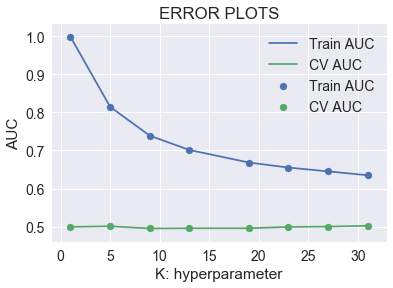

In [93]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(tfidf_train_sent_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_train_sent_vectors)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_cv_sent_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

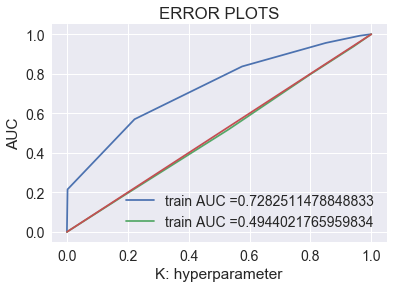

Train confusion matrix
[[  142  3741]
 [  147 20414]]
Test confusion matrix
[[   38  2933]
 [  200 14800]]


In [94]:
neigh = KNeighborsClassifier(n_neighbors=10,algorithm='kd_tree')
neigh.fit(tfidf_train_sent_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_train_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_test_sent_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='-')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(tfidf_train_sent_vectors)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(tfidf_test_sent_vectors)))

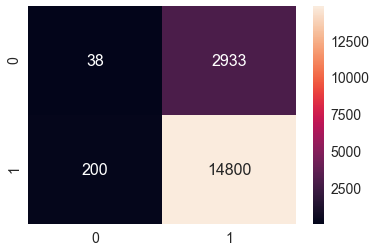

In [95]:
df_cm = pd.DataFrame(confusion_matrix(y_test,neigh.predict(tfidf_test_sent_vectors)), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# [6] Conclusions

In [100]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "Train AUC"]

x.add_row(["BOW", "brute", 10,0.82 ])
x.add_row(["TFIDF", "brute", 15, 0.80])
x.add_row(["Avg W2V", "brute", 10, 0.91])
x.add_row(["TFIDF W2V", "brute", 10, 0.72])
x.add_row(["BOW", "kd_tree", 10, 0.85])
x.add_row(["TFIDF", "kd_tree", 15, 0.77])
x.add_row(["Avg W2V", "kd_tree", 10, 0.73])
x.add_row(["TFIDF W2V", "kd_tree", 10, 0.72])


print(x)

+------------+---------+-----------------+-----------+
| Vectorizer |  Model  | Hyper parameter | Train AUC |
+------------+---------+-----------------+-----------+
|    BOW     |  brute  |        10       |    0.82   |
|   TFIDF    |  brute  |        15       |    0.8    |
|  Avg W2V   |  brute  |        10       |    0.91   |
| TFIDF W2V  |  brute  |        10       |    0.72   |
|    BOW     | kd_tree |        10       |    0.85   |
|   TFIDF    | kd_tree |        15       |    0.77   |
|  Avg W2V   | kd_tree |        10       |    0.73   |
| TFIDF W2V  | kd_tree |        10       |    0.72   |
+------------+---------+-----------------+-----------+
